<a href="https://colab.research.google.com/github/Chirag314/EDA/blob/main/spaceship_titanic2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [130]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [131]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.expand_frame_repr', False)
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)


from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
pd.set_option('max_rows',None)

In [132]:
#Helper functions

#Create function for missing data analysis
def draw_missing_data_table(df):
  total=df.isnull().sum().sort_values(ascending=False)
  percent=(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  missing_data=pd.concat([total,percent],axis=1,keys=['Total','Percent'])
  return missing_data

In [133]:
#Plot learning curve
def plot_learning_curve(estimator, title, x,y,ylim=None, cv=None,n_jobs=1,train_sizes=np.linspace(.1,1,5)):
  plt.figure()
  plt.title(title)
  if ylim is not None:
    plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator,x,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes)
    train_scores_mean=np.mean(train_scores,axis=1)
    train_scores_std=np.std(train_scores,axis=1)
    test_scores_mean=np.mean(test_scores,axis=1)
    test_scores_std=np.std(test_scores,axis=1)
    plt.grid()
    plt.fill_between(train_sizes,train_scores_mean-train_scores_std,train_scores_mean+train_scores_std,alpha=0.1,color='g')
    plt.plot(train_sizes,train_scores_mean,'o-',color='r',label="Training score")
    plt.plot(train_sizes,test_scores_mean,'o-',color='g',label='Validation score')
    plt.legend(loc="best")
    return plt

In [134]:
#plot validation curve
def plot_validation_curve(estimator, title,x,y,param_name,param_range,ylim=None,cv=None,n_jobs=1,train_sizes=np.linspace(.1,1,5)):
  train_scores,test_scores=validation_curve(estimator,x,y,param_name,param_range,cv)
  train_mean=np.mean(train_scores,axis=1)
  train_std=np.std(train_scores,axis=1)
  test_mean=np.mean(test_scores,axis=1)
  test_std=np.std(test_scores,axis=1)
  plt.plot(param_range,train_mean,color='r',marker='o',markersize=5,label='Training Score')
  plt.fill_between(param_range,train_mean+train_std,train_mean-train_std,alpha=0.15,color='r')
  plt.plot(param_range,test_mean,color='g',linstyle='--',marker='s',markersize=5,label='Validation score')
  plt.fill_between(param_range, test_mean+test_std, test_mean-test_std,alpha=0.15,color='g')
  plt.grid()
  plt.xscale('log')
  plt.legend(loc='best')
  plt.xlabel('Parameter')
  plt.ylabel('Score')
  plt.ylim(ylim)

In [135]:
#get path from training and test data
curr_path = os.getcwd()
dataset_src=os.path.join(curr_path,'spaceship titanic')
train_path=os.path.join(dataset_src,'train.csv')
test_path=os.path.join(dataset_src,'test.csv')

In [136]:
#import data
train_df=pd.read_csv(train_path)
test_df=pd.read_csv(test_path)
df=pd.read_csv('train.csv')
df_raw=df.copy()
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Exploratory Data Analysis
Not all features provide necessary information for the model. It is essentil to find out important features for analysis.


In [137]:
# Check for missing values
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [138]:
# Define the function that creates missing value heatmap
def plot_missing_data(dataset, title):
  fig,ax=plt.subplots(figsize=(5,5))
  plt.title(title)
  sns.heatmap(dataset,cbar=False)

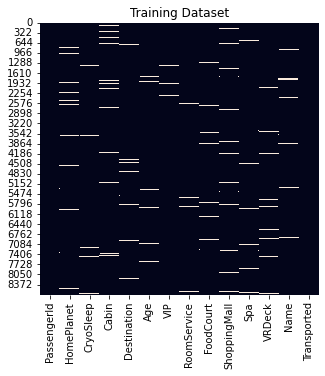

In [139]:
plot_missing_data(df.isnull(),"Training Dataset")

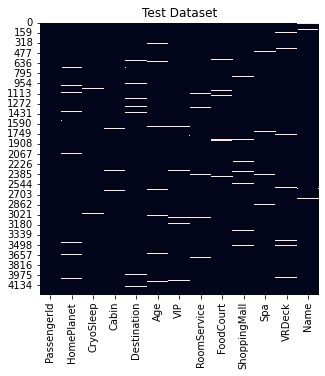

In [140]:
plot_missing_data(test_df.isnull(),"Test Dataset")

In [141]:
# Check number of  missing values in each columns
draw_missing_data_table(train_df)

,Total,Percent
CryoSleep,217,0.024963
ShoppingMall,208,0.023927
VIP,203,0.023352
HomePlanet,201,0.023122
Name,200,0.023007
Cabin,199,0.022892
VRDeck,188,0.021627
FoodCourt,183,0.021051
Spa,183,0.021051
Destination,182,0.020936


In [142]:
# check PassengerId
# Convert passengerid from object to int
from sklearn import preprocessing
lb=preprocessing.LabelEncoder()
train_df['PassengerId']=lb.fit_transform(train_df['PassengerId'])
train_df['PassengerId'].head()

0    0
1    1
2    2
3    3
4    4
Name: PassengerId, dtype: int64

In [143]:
train_df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [144]:
# Fill missing values with 0 temporarily
train_df.HomePlanet=train_df.HomePlanet.fillna('0')
train_df.Cabin= train_df.Cabin.fillna(0)
train_df.CryoSleep=train_df.CryoSleep.fillna(0)
train_df.Destination=train_df.Destination.fillna('0')
train_df.Age= train_df.Age.fillna(0)
train_df.VIP=train_df.VIP.fillna(0)
train_df.RoomService=train_df.RoomService.fillna(0)
train_df.FoodCourt=train_df.FoodCourt.fillna(0)
train_df.ShoppingMall=train_df.ShoppingMall.fillna(0)
train_df.Spa=train_df.Spa.fillna(0)
train_df.VRDeck=train_df.VRDeck.fillna(0)
train_df.Name=train_df.Name.fillna('0')

In [145]:
train_df.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

In [146]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   int64  
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   object 
 3   Cabin         8693 non-null   object 
 4   Destination   8693 non-null   object 
 5   Age           8693 non-null   float64
 6   VIP           8693 non-null   object 
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Name          8693 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), int64(1), object(6)
memory usage: 891.5+ KB


In [151]:
features=['PassengerId', 'HomePlanet', 'CryoSleep','Cabin',
          'Destination','Age','VIP','RoomService','FoodCourt',
          'ShoppingMall','Spa','VRDeck','Name','Transported']

In [148]:
# Convert all float values to integer
train_df.RoomService=train_df.RoomService.astype(int)
train_df.Age=train_df.Age.astype(int)
train_df.FoodCourt=train_df.FoodCourt.astype(int)
train_df.ShoppigMall=train_df.ShoppingMall.astype(int)
train_df.Spa=train_df.Spa.astype(int)
train_df.VRDeck=train_df.VRDeck.astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


In [149]:
# Remove unnecessary strings from Destination
train_df.Destination= train_df.Destination.replace({'TRAPPIST-1e':'TRAPPIST',
                                                    '55 Cancri e':'Cancri',
                                                    'PSO J318.5-22':'PSO'})
#train_df.Destination.head()
# Convert boolean to integer for Transported
train_df.Transported=train_df.Transported.replace(True,1).replace(False,0)
train_df.Transported.head()

0    0
1    1
2    0
3    0
4    1
Name: Transported, dtype: int64

In [152]:
x=train_df[features]
#x=train_df.drop(columns=["Cabin" , 'Name', 'Transported'])
x=x.to_list()


AttributeError: ignored

In [ ]:
#Define Features and Label
features = ['posted_by', 'under_construction', 'rera', 'bhk_no.', 'bhk_or_rk',
            'square_ft', 'ready_to_move', 'resale', 'longitude',
            'latitude'] 

X=train[features].values
y=train['target(price_in_lacs)'].values


In [112]:
y=train_df["Transported"].to_list()
y.head()

0    0
1    1
2    0
3    0
4    1
Name: Transported, dtype: int64

In [113]:
x['Destination'].unique()
x.iloc[:,3].unique()

array(['TRAPPIST', 'PSO', 'Cancri', '0'], dtype=object)

In [114]:
# Define arrays for nominal , ordinal, numeric and binary variables
nom=[1,2,3,5]
num=[0,6,7,8,9,10]
bin=[4]

In [115]:
# Tranform columns based on type
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,PowerTransformer,Binarizer
from sklearn.compose import make_column_transformer
from sklearn import set_config

trans=make_column_transformer((OneHotEncoder(sparse=False),nom),
                               (PowerTransformer(),num),
                               (Binarizer(),bin),
                               remainder='passthrough')
set_config(display='diagram')
trans

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(sparse=False),
                                 [1, 2, 3, 5]),
                                ('powertransformer', PowerTransformer(),
                                 [0, 6, 7, 8, 9, 10]),
                                ('binarizer', Binarizer(), [4])])

In [116]:
x_train,x_test, y_train, y_test=train_test_split(x,y,test_size=0.75)

In [117]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 3609 to 7025
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   2173 non-null   int64  
 1   HomePlanet    2173 non-null   object 
 2   CryoSleep     2173 non-null   object 
 3   Destination   2173 non-null   object 
 4   Age           2173 non-null   int64  
 5   VIP           2173 non-null   object 
 6   RoomService   2173 non-null   int64  
 7   FoodCourt     2173 non-null   int64  
 8   ShoppingMall  2173 non-null   float64
 9   Spa           2173 non-null   int64  
 10  VRDeck        2173 non-null   int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 203.7+ KB


In [90]:
# Convert numeric variables to float
numeric_list = x_train.select_dtypes(include=[np.number]).columns
x_train[numeric_list] = x_train[numeric_list].astype(np.float32)

In [118]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 3609 to 7025
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   2173 non-null   int64  
 1   HomePlanet    2173 non-null   object 
 2   CryoSleep     2173 non-null   object 
 3   Destination   2173 non-null   object 
 4   Age           2173 non-null   int64  
 5   VIP           2173 non-null   object 
 6   RoomService   2173 non-null   int64  
 7   FoodCourt     2173 non-null   int64  
 8   ShoppingMall  2173 non-null   float64
 9   Spa           2173 non-null   int64  
 10  VRDeck        2173 non-null   int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 203.7+ KB


Use neural network to predict binary variable. We will use tensorflow and keras to model and predict values


In [119]:
#Use NN to predict transported column
import tensorflow as tf
# Set random seed
tf.random.set_seed(42)

# Create a model
model_1=tf.keras.Sequential([
                             tf.keras.layers.Dense(100,activation=tf.keras.activations.relu),
                             tf.keras.layers.Dense(10,activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])

#Compile the model
model_1.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(lr=0.001),
                metrics=['accuracy'])

#fit the model
history = model_1.fit(x_train,y_train,epochs=100)

#model_1.evaulate(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


ValueError: ignored

In [ ]:
# Evaluate model on test set
loss,accuracy=model_1.evaluate(x_test,y_test)

53/53 [==============================] - 0s 1ms/step - loss: 0.5008 - accuracy: 0.7599


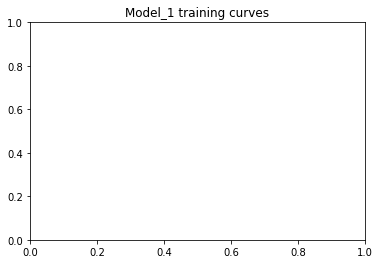

In [ ]:
# plot the loss curves
pd.DataFrame(history.history).plot
plt.title('Model_1 training curves')
plt.show()

In [ ]:
#y_prob = model.predict(x) 
#y_classes = y_prob.argmax(axis=-1)
prd1=model_1.predict(test)


In [ ]:
test1.head()


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [ ]:
#normalize the data
test2=test1[['PassengerId']]
test2['Trans']=prd1
#test2['Transported'].value_counts(normalize=True)
test2.head()

,PassengerId,Trans
0,0013_01,0.703252
1,0018_01,0.018758
2,0019_01,0.986932
3,0021_01,0.703252
4,0023_01,0.703252


In [ ]:
test2.loc[test2['Trans'] < 0.5, 'Transported'] = 'False' 
test2.loc[test2['Trans'] >= 0.5, 'Transported'] = 'True' 
test2.drop('Trans',axis=1,inplace=True)

In [ ]:
test2.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [ ]:
test2.to_csv("Submission_nn.csv", index=False)

##### LEts do feature importance and check which features are important using random forest classifier


In [ ]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(x_train,y_train)

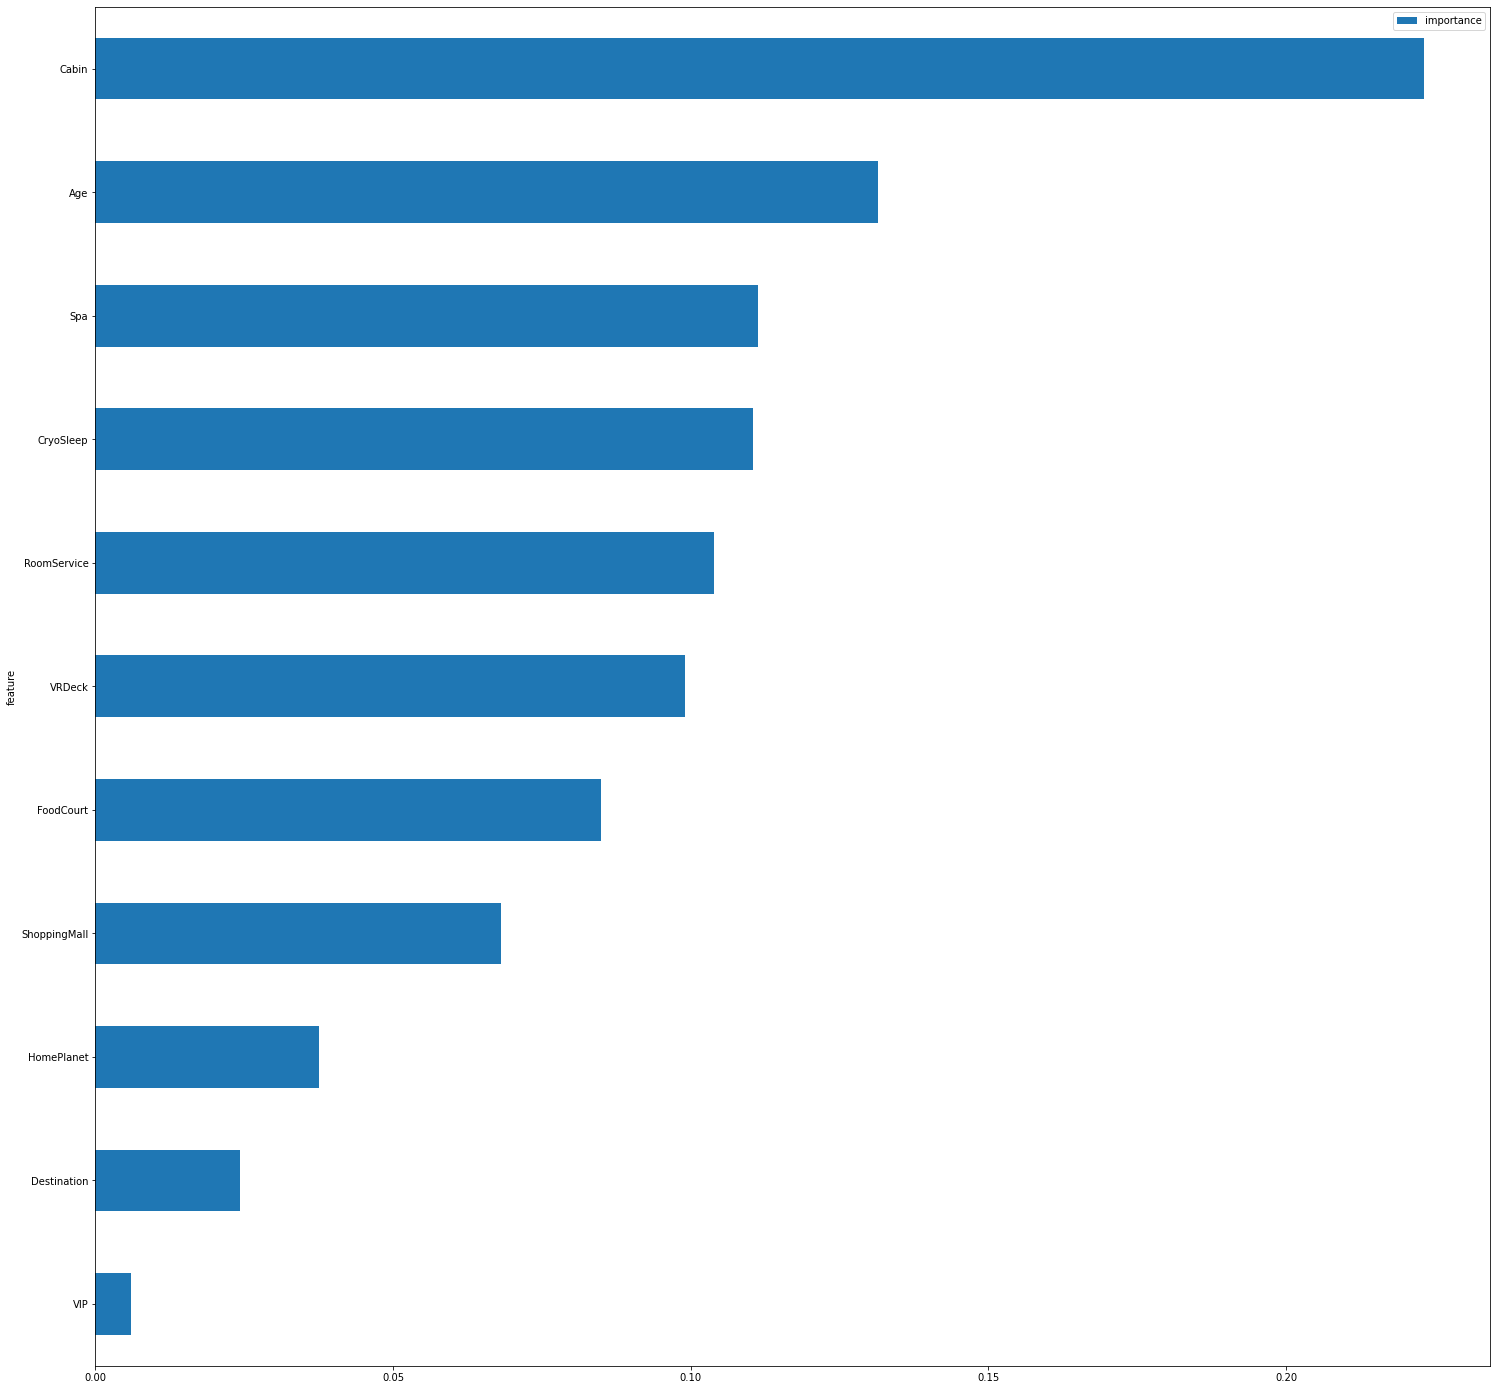

In [ ]:
features=pd.DataFrame()
features['feature']=x_train.columns

features['importance']=clf.feature_importances_
features.sort_values(by=['importance'],ascending=True,inplace=True)

features.set_index('feature',inplace=True)
features.plot(kind='barh',figsize=(25,25))


In [ ]:
# lets transform our train and test set in more compact dataset

model=SelectFromModel(clf,prefit=True)
train_reduced=model.transform(x_train)

print(train_reduced.shape)

(6778, 6)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


#####Our dataset has become very compact. Before we had 14 features, now we only have 6.

In [ ]:
test_reduced=model.transform(test)

print(test_reduced.shape)

(4277, 6)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
from sklearn.tree import DecisionTreeClassifier
d=DecisionTreeClassifier()
d.fit(train_reduced,y_train)
y_pred=d.predict(test_reduced)

#print(accuracy_score(y_test,y_pred))


In [ ]:
test3=test1[['PassengerId']]
test3['Transported']=y_pred
#test2['Transported'].value_counts(normalize=True)
test3.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [ ]:
test3.to_csv("Submission_dt.csv", index=False)

In [ ]:
# Gradient boosting 
from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier()
gbc.fit(train_reduced,y_train)
y_pred=d.predict(test_reduced)
y_pred

array([ True, False,  True, ...,  True,  True,  True])

In [ ]:
test4=test1[['PassengerId']]
test4['Transported']=y_pred
#test2['Transported'].value_counts(normalize=True)
test4.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [ ]:
test4.to_csv("Submission_GB.csv", index=False)

######Gradient boosting algorithm

In [ ]:
import lightgbm as lgb
clf=lgb.LGBMClassifier()
test_reduced
clf.fit(train_reduced,y_train)

LGBMClassifier()

In [ ]:
y_pred=clf.predict(test_reduced)
y_pred

array([ True, False,  True, ...,  True,  True,  True])

In [ ]:
test5=test1[['PassengerId']]
test5['Transported']=y_pred
#test2['Transported'].value_counts(normalize=True)
test5.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [ ]:
test5.to_csv("Submission_LGBm.csv", index=False)